In [406]:
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error

# Carga de datos y creación de DB

Como la data del problema esta en el archivo trips.csv y se nos pide trabajar desde una DB en SQL, se creará la DB en MySQL la database trips, con la tabla movimientos en donde se almacenará la información

In [407]:
df = pd.read_csv('trips.csv')
df.columns

Index(['region', 'origin_coord', 'destination_coord', 'datetime',
       'datasource'],
      dtype='object')

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   region             100 non-null    object
 1   origin_coord       100 non-null    object
 2   destination_coord  100 non-null    object
 3   datetime           100 non-null    object
 4   datasource         100 non-null    object
dtypes: object(5)
memory usage: 4.0+ KB


In [409]:
df.head()

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
2,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app


In [410]:
# Definimos la función para crear la conexión al servidor
def create_server_connection(host_name, user_name, user_password):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

# Definimos la función para crear la base de datos
def create_database(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Database created successfully")
    except Error as err:
        print(f"Error: '{err}'")

In [411]:
# Nos conectamos al servidor
connection = create_server_connection("localhost", "root", "NW_server_pw")
# Creamos la base de datos
create_database(connection, "CREATE DATABASE trips")

MySQL Database connection successful
Error: '1007 (HY000): Can't create database 'trips'; database exists'


In [412]:
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")

In [413]:
# Query para crear la tabla viajes
create_viaje_table = """
CREATE TABLE viajes (
  region VARCHAR(7) NOT NULL,
  origin_coord VARCHAR(50) NOT NULL,
  destination_coord VARCHAR(50) NOT NULL,
  datetime DATETIME NOT NULL,
  datasource VARCHAR(20) NOT NULL
  );
 """

# Nos conectamos a la base de datos
connection = create_db_connection("localhost", "root", "NW_server_pw", "trips")
# Ejecutamos la query
execute_query(connection, create_viaje_table) 

MySQL Database connection successful
Query successful


In [414]:
cols = "`,`".join([str(i) for i in df.columns.tolist()])
cursor = connection.cursor()

# Insertamos las filas del DataFrame una por una
for i,row in df.iterrows():
    sql = "INSERT INTO `viajes` (`" +cols + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cursor.execute(sql, tuple(row))
    connection.commit()

In [415]:
# Terminamos la conexión con la base de datos
connection.close()

 # Conexión a la DB
 
 Ahora se asume que la información en la base de datos esta actualizada y solo se necesita conectarse desde Python para trabajar en el problema

In [416]:
# Nos conectamos a la base de datos 'trips'
connection = create_db_connection("localhost", "root", "NW_server_pw", "trips")

MySQL Database connection successful


In [417]:
# Cargamos la información de la base de datos a un dataframe
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM viajes
                               ''', connection)

data= pd.DataFrame(sql_query, columns = ["region", "origin_coord", "destination_coord",
                                        "datetime", "datasource"])
data.head()

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
2,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app


In [418]:
# Terminamos la conexión con la base de datos
connection.close()

# Problema 1

In [929]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [930]:
# Definimos función que transforma las coordenadas en pares
def to_coord(col, data = data):
    aux = data[col]
    new_col = np.empty([len(aux),2])
    for i in range(len(aux)):
        x,y = aux[aux.index[i]][7:-1].split()
        new_col[i,:] = np.array([x,y]) 
    return new_col

In [931]:
# Coordenadas origen y destino en arrays numéricos
new_origin = to_coord('origin_coord')
new_destin = to_coord('destination_coord')

### Modelos para agrupar viajes por origen-destino y hora

En primera instancia hacemos k-means para agrupar viajes similares, sin considerar los horarios del viaje

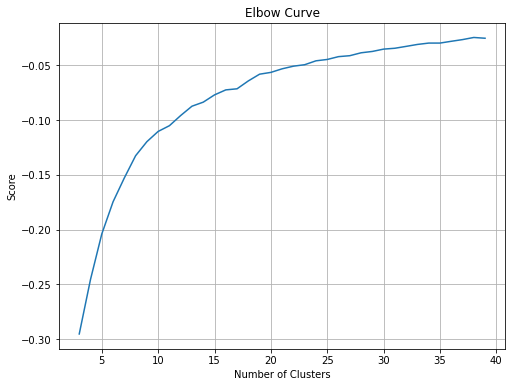

In [947]:
X = np.empty([len(data),4])
X[:,0] = new_origin[:,0]
X[:,1] = new_destin[:,0]
X[:,2] = new_origin[:,1]
X[:,3] = new_destin[:,1]

# Estandarizamos las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Nc = range(3, 40)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.plot(Nc,score)
plt.grid()
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

El gráfico sugiere una división de 16 grupos 

In [934]:
kmeans_geo = KMeans(n_clusters=16).fit(X_scaled)
centroids_geo = kmeans_geo.cluster_centers_

Luego, hacemos k-means por horario del viaje, para identificar viajes similares según su hora del día

In [935]:
#Recive array de datetime y retorna en un array la hora del día de cada datetime en segundos
def time_to_num(array):
    # Aislamos la hora (hh,mm,ss) de cada viaje 
    hora = np.array([array[array.index[i]].time() for i in range(len(array))])
    # Pasamos la hora a segundos de manera numérica
    hora_num = np.array([hora[i].hour*(60**2)+hora[i].minute*60+hora[i].second for i in range(len(array))])
    return hora_num

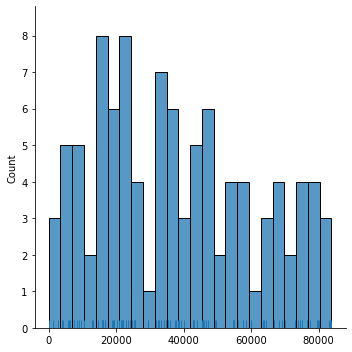

In [936]:
hora_num  = time_to_num(data['datetime'])

#visualizamos la distribución de los viajes 
#cada barra agrupa 1 hora del día
sns.displot(hora_num, bins=24, rug=True)
plt.show()

Según el histograma y considerando que se tienen que asociar viajes de horarios similares se decide realizar 7 grupos horarios estos serían:

0. 00:00:00 a 03:29:59 
1. 03:30:00 a 07:59:59 
2. 08:00:00 a 11:29:59 
3. 11:30:00 a 14:29:59 
4. 14:30:00 a 17:29:59 
5. 17:30:00 a 20:29:59
6. 20:30:00 a 23:59:59


In [953]:
#En base a los grupos horarios definimos una funcion que entrega etiquetas (0 a 6)
#según el horario del viaje de forma numérica
def time_tags(horas):
    tags = []
    for i in range(len(horas)):
        if horas[i]<(3*60**2+30*60):
            tags.append(0)
        elif horas[i]<(8*60**2):
            tags.append(1)
        elif horas[i]<(11*60**2+30*60):
            tags.append(2)
        elif horas[i]<(14*60**2+30*60):
            tags.append(3)
        elif horas[i]<(17*60**2+30*60):
            tags.append(4)
        elif horas[i]<(20*60**2+30*60):
            tags.append(5)
        else:
            tags.append(6)
    return tags

### Agrupamos los viajes

Juntamos las dos etiquetas, por coordenadas del viaje y por hora del viaje para realizar la agrupación de los traslados origen-destino-hora similares según los k-means realizados

In [938]:
#creamos las etiquetas de los viajes según origen-destino y según hora del viaje
labels_geo = kmeans_geo.predict(X_scaled)
labels_time = time_tags(hora_num)

#juntamos las etiquetas en una etiqueta doble
tags = [str(labels_geo[i])+','+str(labels_time[i]) for i in range(len(labels_geo))]

#agregamos la etiqueta a nuestro dataframe para asociarlas cada viaje
data['label'] = tags

In [948]:
#creamos un nuevo dataframe con las etiquetas y su cuenta
df_grouped = data.groupby(['label'])['region'].count().reset_index()
df_grouped.rename({'region':'count'},axis=1,inplace=True)

### Trabajar nueva data

Así, cuando llegue nueva data basta aplicar al nuevo dataframe la función add_to_grouped (definida a continuación), que llama a new_data_tags para conseguir la etiqueta de cada viaje nuevo y luego, los agrega a df_grouped si no está la etiqueta, o suma 1 al contador con la misma etiqueta por cada viaje nuevo agregado.

In [950]:
def new_data_tags(df):
    #label del viaje por origen-destino
    new_origin = to_coord('origin_coord', df)
    new_destin = to_coord('destination_coord', df)
    X = np.empty([len(df),4])
    X[:,0] = new_origin[:,0]
    X[:,1] = new_destin[:,0]
    X[:,2] = new_origin[:,1]
    X[:,3] = new_destin[:,1]
    #scaler ya esta entrenado
    X_scaled = scaler.transform(X)
    #kmeans ya entrenado
    labels_geo = kmeans_geo.predict(X_scaled)
    
    #label del viaje por su hora
    hora_num = time_to_num(df['datetime'])
    labels_time = time_tags(hora_num)
    
    #juntamos las etiquetas en una etiqueta doble
    tags = [str(labels_geo[i])+','+str(labels_time[i]) for i in range(len(labels_geo))]
    
    return tags

def add_to_grouped(df):
    #genereramos las etiquetas de los nuevos viajes
    tags = new_data_tags(df)
    for t in tags:
        tag_ind = df_grouped[df_grouped['label']==t].index
        if len(tag_ind)>0:   #se suma 1 al contador si está la etiqueta
            df_grouped.iloc[tag_ind,1]+=1                    
        else:                #se agrega la etiqueta al final del dataframe si no existía
            df_grouped.loc[len(df_grouped)] = [t,1]
    

In [949]:
df_grouped

,label,count
0,"0,0",2
1,"0,1",2
2,"0,2",1
3,"0,3",1
4,"0,4",3
...,...,...
61,"8,4",1
62,"9,0",1
63,"9,2",2
64,"9,4",1


In [951]:
#Ejemplo

#La etiqueta '9,4' está en df_grouped 1 vez, pero '9,3' no está, por lo que agregaremos un
#viaje '9,4' y uno '9,3' para evaluar ambos casos, para esto tomaremos el mismo viaje con 
#etiqueta '9,4' y le cambiaremos el horario a 12:00:00 para que su nueva etiqueta sea '9,3'.

new_df = data[data['label']=='9,4'].copy()
new_trip = new_df.iloc[0,:]
new_trip.iloc[3] = pd.to_datetime('2018-05-20 12:00:00')
new_df.loc[1,:] = new_trip

D:\Users\piper\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\Users\piper\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [952]:
add_to_grouped(new_df)
df_grouped

,label,count
0,"0,0",2
1,"0,1",2
2,"0,2",1
3,"0,3",1
4,"0,4",3
...,...,...
62,"9,0",1
63,"9,2",2
64,"9,4",2
65,"9,5",2


# Problema 2

In [964]:
#Se asume que el bounding box se entrega como coordenadas x1,y1,x2,y2, donde x1<=x2 e y1<=y2
#Se entiende que tanto el origen como el destino tienen que estar dentro del bounding box
def weekly_mean(x1,y1,x2,y2,region):
    #query región
    data_reg = data[data['region'] == region].copy()
    
    #pasamos las coordenadas a pares numéricos
    new_origen = to_coord('origin_coord', data_reg)
    new_destin = to_coord('destination_coord', data_reg)
    
    #Se filtra los viajes dentro de la bounding box
    low_bound = [all(new_origen[i] >= [x1,y1]) and all(new_destin[i] >= [x1,y1]) 
                 for i in range(len(data_reg))]
    up_bound = [all(new_origen[i] <= [x2,y2]) and all(new_destin[i] <= [x2,y2]) 
                 for i in range(len(data_reg))]
    #query bounding box
    data_bound = data_reg[low_bound and up_bound]
    
    #agrupamos por semana y sacamos promedio
    week_mean = data_bound.groupby(pd.Grouper(key='datetime', freq='W-MON', label='left')
                        )['datetime'].count().mean()
    
    #opciones de entrega de la respuesta como un string o numérico
    print('Promedio de viajes semanal = '+str(week_mean))
    return week_mean

In [965]:
#testeo region 'Prague'
wm = weekly_mean(0,0,100,100,'Prague')

Promedio de viajes semanal = 6.8


## Estado de la ingesta de datos

Para este último problema se creará un trigger en caso de que se agregue nueva data a nuestra base de datos en SQL lo que nos indicará que nuestro dataframe en Python no esta actualizado. Se crean tres trigger (update, insert y delete) y además, se crea la tabla cambios para almacenar información sobre cambios en la tabla viajes.

In [969]:
# Nos conectamos a la base de datos 'trips'
connection = create_db_connection("localhost", "root", "NW_server_pw", "trips")

# Query para crear la tabla cambios
create_cambios_table = """
CREATE TABLE cambios (
  state VARCHAR(8) NOT NULL
  );
 """

# Query para crear update trigger
create_update_trigger = """
CREATE TRIGGER update_trigger 
AFTER UPDATE
ON viajes FOR EACH ROW
BEGIN
    INSERT INTO cambios
    (state)
    VALUES
    ('UPDATED');
END;
"""

# Query para crear insert trigger
create_insert_trigger = """
CREATE TRIGGER insert_trigger 
AFTER INSERT
ON viajes FOR EACH ROW
BEGIN
    INSERT INTO cambios
    (state)
    VALUES
    ('INSERTED');
END;
"""

# Query para crear delete_trigger
create_delete_trigger = """
CREATE TRIGGER delete_trigger 
AFTER DELETE
ON viajes FOR EACH ROW
BEGIN
    INSERT INTO cambios
    (state)
    VALUES
    ('DELETED');
END;
"""

# Ejecutamos las querys
execute_query(connection, create_cambios_table) 
execute_query(connection, create_update_trigger)
execute_query(connection, create_insert_trigger)
execute_query(connection, create_delete_trigger)

#terminamos la conexión 
connection.close()

MySQL Database connection successful
Error: '1050 (42S01): Table 'cambios' already exists'
Query successful
Query successful
Query successful


Luego, basta saber el largo de la tabla cambios al momento de ingerir los datos desde SQL para poder responder a la pregunta de si han habido cambios en la base de datos.

In [970]:
# Nos conectamos a la base de datos 'trips' 
connection = create_db_connection("localhost", "root", "NW_server_pw", "trips")

sql_query_cambios = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM cambios
                               ''', connection)

data_cambios= pd.DataFrame(sql_query_cambios, columns = ['state'])

#terminamos la conexión 
connection.close()

actual = len(data_cambios)

MySQL Database connection successful


In [976]:
# Definimos la función que nos entrega el estado de la ingesta de datos
def ingest_state(actual):
    # Nos conectamos a la base de datos 'trips' 
    connection = create_db_connection("localhost", "root", "NW_server_pw", "trips")

    sql_query_cambios = pd.read_sql_query ('''
                                   SELECT
                                   *
                                   FROM cambios
                                   ''', connection)
    
    data= pd.DataFrame(sql_query_cambios, columns = ['state'])

    #terminamos la conexión 
    connection.close()
    
    new = len(data)
    
    #Preguntamos si hubieron nuevos cambios
    if new>actual:
        state = 'desactualizado'
    else:
        state = 'actualizado'
    
    print('El estado de la ingesta de datos está ' + state)
        
    

In [977]:
#test
ingest_state(actual)

MySQL Database connection successful
El estado de la ingesta de datos está actualizado
